Import libraries and set PyPlot Standarts for Dynamic Plotting

In [66]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use('seaborn-whitegrid')
plt.rcParams.update({'font.size': 9})
plt.ion()
import os
import shutil
import numpy as np
import pandas as pd
import imageio

def custom_plot(title: str, route: [str], nodes: pd.DataFrame):
    '''
    Plots a given solution of the TSP
    '''
    plt.figure(title)
    plt.title(title)
    plt.scatter(nodes.loc['Node 0', 'X'], nodes.loc['Node 0', 'Y'], c = 'Red', label = 'Node 0')
    plt.scatter(nodes.loc['Node 1':, 'X'], nodes.loc['Node 1':,'Y'], c = 'Blue', label = 'Nodes to visit')
    plt.plot(nodes.loc[route, 'X'], nodes.loc[route, 'Y'])

def dynamic_plot(iteration: int, route: [str], nodes: pd.DataFrame, canvas, axis, current, save = True):
    '''
    Updates a Dynamic Plot where the progress of the algorithm is shown
    '''
    axis.set_title('Iteration ' + str(iteration))
    canvas.canvas.flush_events()
    if iteration == 1:
        axis.scatter(nodes.loc['Node 0', 'X'], nodes.loc['Node 0', 'Y'], c = 'Red', label = 'Node 0')
        axis.scatter(nodes.loc['Node 1':, 'X'], nodes.loc['Node 1':,'Y'], c = 'Blue', label = 'Nodes to visit')
    current.set_xdata(nodes.loc[route, 'X'])
    current.set_ydata(nodes.loc[route, 'Y'])
    canvas.canvas.draw()
    if save:
        canvas.savefig(f'Sample Images/img_{iteration}.png')

Establish dataset generation functions

In [67]:
def euclidean_distance(point1: (float), point2: (float)):
    '''
    Returns the euclidean distance between two points
    '''
    return np.sqrt((point1[0]-point2[0])**2 + (point1[1]-point2[1])**2)

def objective_value(route: [str], nodes: pd.DataFrame , matrix: pd.DataFrame) -> int:
    '''
    Calculates the objective value (Total distance) of a given TSP Solution
    '''
    total = 0
    for i in range(len(route)-1):
        total += euclidean_distance(point1 = nodes.loc[route[i], ['X', 'Y']], point2 = nodes.loc[route[i+1], ['X', 'Y']])
    return total

def generate_set(nodes: int, center: (float), std: float) -> pd.DataFrame:
    '''
    Generates a sample dataset using normal distribution with its distance matrix included
    '''
    # Establish Node 0
    main_x = center[0]
    main_y = center[1]

    # Define Final Shape of Info
    final_shape = (nodes+1, 2)
    # Define Final Shape of Matrix
    matrix_shape = (nodes+1, nodes+1)

    # Generate Sample Data
    nodesinfo = np.append(np.array(((main_x, main_y))),np.array(((np.random.normal(main_x, std, nodes), np.random.normal(main_y, std, nodes))))).T
    nodesinfo = np.reshape(nodesinfo, final_shape)

    #Generate IDs and Dataframe of Info
    nodeslayers = [f'Node {i}' for i in range(nodes+1)]
    nodes = pd.DataFrame(nodesinfo, index = nodeslayers, columns= ['X', 'Y'])

    #Generate Distance Matrix

    distance_matrix = []

    for node in nodes.index:
        distances = [euclidean_distance(point1 = nodes.loc[node, ['X', 'Y']], point2 = nodes.loc[next_node, ['X', 'Y']]) for next_node in nodes.index]
        distance_matrix = np.append(distance_matrix, distances)
    
    distance_matrix = np.reshape(distance_matrix, matrix_shape)
    distance_matrix = pd.DataFrame(distance_matrix, index = nodes.index, columns = nodes.index)

        
    
    return nodes, distance_matrix

Generate sample dataset and visualize it

Text(0.5, 1.0, 'Distribution of node network')

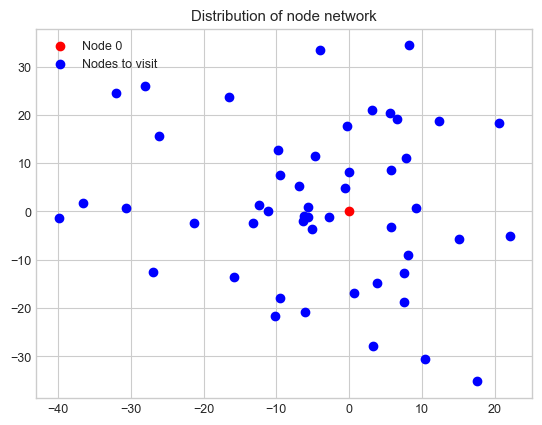

In [68]:
np.random.seed(2)
nodes, matrix = generate_set(nodes = 50, center = (0,0), std = 15)
node_distribution = plt.figure('Distribution of node network')
plt.title('Distribution of node network')
plt.scatter(nodes.loc['Node 0', 'X'], nodes.loc['Node 0', 'Y'], c = 'Red', label = 'Node 0')
plt.scatter(nodes.loc['Node 1':, 'X'], nodes.loc['Node 1':,'Y'], c = 'Blue', label = 'Nodes to visit')
plt.legend()

Define how initial solutions are generated

In [69]:
def random_solution(nodes: pd.DataFrame) -> [str]:
    '''
    Generates a Random TSP Solution for a given set of nodes
    '''
    route = [nodes.index[0]]
    while len(route) < nodes.shape[0]:
        mynode = np.random.choice(nodes.index)
        if mynode not in route:
            route.append(mynode)
    route.append(nodes.index[0])
    return route

def nearest_neighbor(nodes: pd.DataFrame, matrix: pd.DataFrame) -> [str]:
    '''
    Generates a TSP solution for a set of nodes based in the Nearest Neighbor algorithm
    '''
    route = [nodes.index[0]]
    while len(route) < nodes.shape[0]:
        for node in nodes.index:
            # Get the boolean mask for the routing list (Mask is a Boolean Array that matches a certain condition, like .loc conditionals)
            mask = ~matrix.columns.isin(route)
            if mask.any():
                # Find the minimum distance for nodes not in the routing list
                min_node = matrix.loc[:, route[-1]][mask].idxmin()
                # Append the node to the routing list
                route.append(min_node)
    route.append(nodes.index[0])
    return route

Generate initial solutions

In [70]:
random = random_solution(nodes)
nn = nearest_neighbor(nodes, matrix)

Plot Initial Solutions

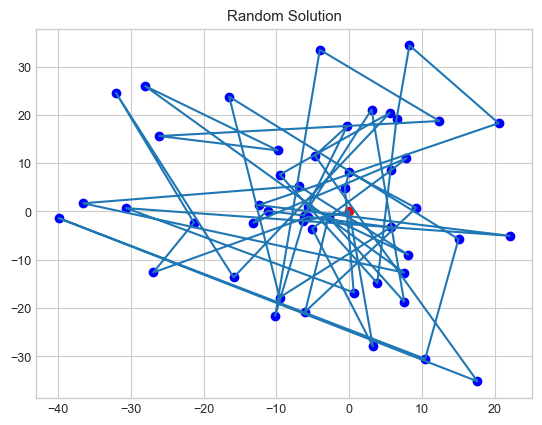

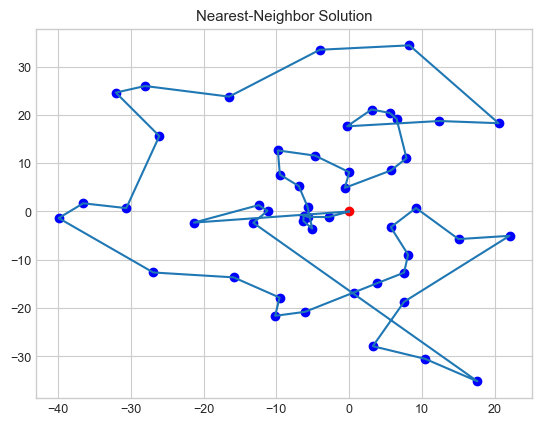

In [71]:
custom_plot('Random Solution', random, nodes)
custom_plot('Nearest-Neighbor Solution', nn, nodes)

Define perturbation/improvement criterias

In [72]:
def twoopt(route: [str], matrix: pd.DataFrame) -> [str]:
    '''
    Applies 2-opt improvement if possible
    '''
    min_change = 0
    for i in range(len(route)-2):
        for j in range(i+2,len(route)-1):
            change = matrix.loc[route[i], route[j]] + matrix.loc[route[i+1], route[j+1]]-matrix.loc[route[i], route[i+1]]-matrix.loc[route[j], route[j+1]]
            if change < min_change:
                min_change = change
                min_i = i
                min_j = j
    if min_change < 0:
        route[min_i+1:min_j+1] = route[min_i+1:min_j+1][::-1]
    return route
def random_swap(route: [str]) -> [str]:
    '''
    Randomly swaps two nodes in a solution (Node 0 excluded) 
    '''
    available_nodes = range(1, len(route)-1)
    while True:
        first_id = np.random.choice(available_nodes)
        second_id = np.random.choice(available_nodes)
        if first_id != second_id:
            break
    first = route[first_id]
    second = route[second_id]
    temp = first
    route[first_id] = second
    route[second_id] = temp
    return route

Define Metaheuristic Methods

In [73]:
def simmulated_annealing(nodes: pd.DataFrame, matrix: pd.DataFrame, route: [str], steps: int) -> [str]:
    '''
    Performs Simulated Annealing Metaheuristic to a given initial solution
    '''
    prevSol = route.copy()
    objectives = []
    iterations = range(1, steps+1)
    frames = []
    for i in range(steps):
        temperature = (50/np.log(i+2))
        neighbor = prevSol.copy()
        dynamic_plot(i+1, neighbor, nodes, canvas, ax, current)
        image = imageio.v2.imread(f'Sample Images/img_{i+1}.png')
        frames.append(image)
        old = objective_value(prevSol, nodes, matrix)
        objectives.append(old)
        # Perturbate Solution
        p = np.random.random()
        if p <= 0.2:
            neighbor = twoopt(neighbor, matrix)
        else:
            neighbor = random_swap(neighbor)
        new = objective_value(neighbor, nodes, matrix)
        if new < old:
            prevSol = neighbor
        else:
            p = np.exp(-(new - old) / temperature)
            c = np.random.random()
            if p >= c:
                prevSol = neighbor
    plt.figure('Simmulated Annealing Progress')
    plt.title('Simmulated Annealing Progress')
    plt.plot(iterations, objectives)
    return frames


Execute Simmulated Annealing based on Initial Random Solution

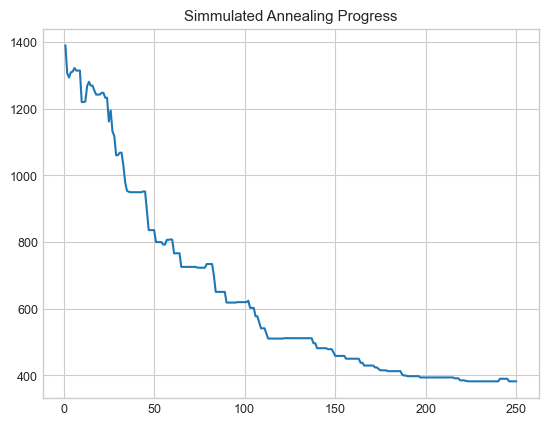

In [74]:
canvas, ax = plt.subplots(num = 'Dynamic Graphic')
current, = ax.plot(0,0)
plt.close()
os.mkdir('Sample Images')
frames = simmulated_annealing(nodes, matrix, random, 250)
imageio.mimsave('Simulated Annealing Process.gif', # output gif
                frames,        # array of input frames
                fps = 15,      # optional: frames per second
                loop = 1)
shutil.rmtree('Sample Images')


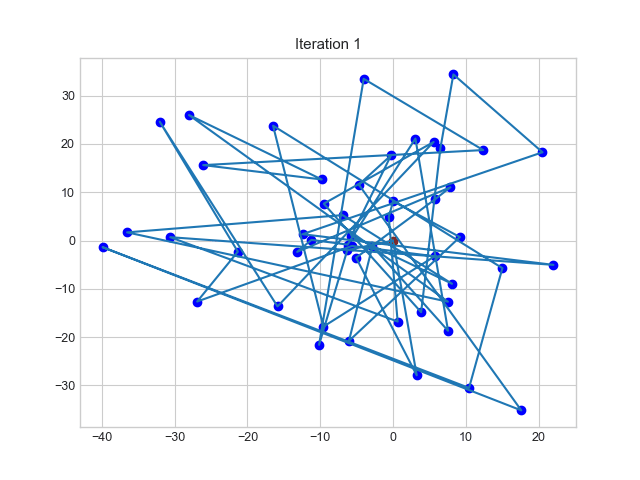

In [75]:
from IPython.display import Image, display

# path to the gif file
filepath = 'Simulated Annealing Process.gif'

# display the gif in the notebook
display(Image(filename=filepath))